<a href="https://colab.research.google.com/github/PabloDome/Microcopio/blob/main/BobinasHemholtz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

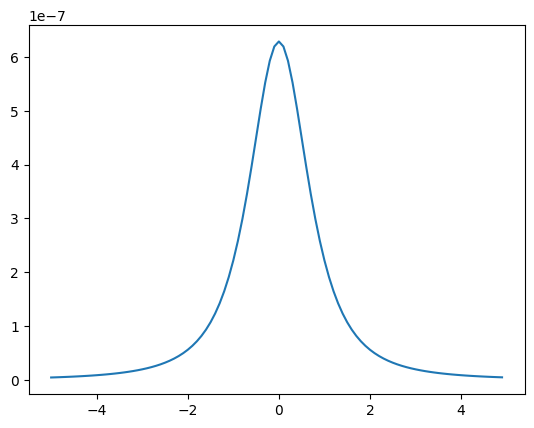

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit


def BitSabart(I, r, r_bob, Radio_bob):
  theta = np.linspace(0, 2*np.pi, num=100, endpoint=True) # num es la cantidad de divisiones de integración
  Bx = pow(10,-7)*I*np.trapz((r_bob[2]-r[2])*np.cos(theta)/pow((pow(-r[0]+r_bob[0]+Radio_bob*np.cos(theta),2)+pow(-r[1]+r_bob[1]+Radio_bob*np.sin(theta),2)+pow(-r[2]+r_bob[2],2)),3/2), theta)
  By = pow(10,-7)*I*np.trapz((r_bob[2]-r[2])*np.sin(theta)/pow((pow(-r[0]+r_bob[0]+Radio_bob*np.cos(theta),2)+pow(-r[1]+r_bob[1]+Radio_bob*np.sin(theta),2)+pow(-r[2]+r_bob[2],2)),3/2), theta)
  Bz = pow(10,-7)*I*np.trapz(((r_bob[1]-r[1])*np.sin(theta)+(r_bob[0]-r[0])*np.cos(theta)+Radio_bob)/pow((pow(-r[0]+r_bob[0]+Radio_bob*np.cos(theta),2)+pow(-r[1]+r_bob[1]+Radio_bob*np.sin(theta),2)+pow(-r[2]+r_bob[2],2)),1.5), theta)

  B = np.array([0, 0, Bz])

  return B

R_max = 10
Tam = 100

I = 1 # en Amperes
Radio_bob = 1 # en cm
r_bob = np.array([0, 0, 0]) #Posición de la espira en cm
B_punto = np.zeros(3)
B = []
r_pos = []

for i in range(Tam):
  r = np.array([0, 0, (i-Tam*0.5)*R_max/Tam])
  B_punto = BitSabart(I, r, r_bob, Radio_bob)
  B.append(B_punto[2])
  r_pos.append((i-Tam*0.5)*R_max/Tam)

plt.plot(r_pos[:],B[:])

